# Totango SFTP Job Log API Script

## Summary

This script is a part of the efforts to enhance data management and monitoring in Totango. It is designed to fetch the details of all data jobs, whether they are running on SFTP or non-SFTP, that are currently operating in Totango. The aim of the script is to facilitate the creation of a day-to-day load monitoring dashboard, enabling us to take quick remedial action in case any job fails.

## Key Features

1. This script interacts with Totango APIs to gather information about all the SFTP and non-SFTP data jobs running on Totango.
<br>
2. The acquired data is instrumental in creating a comprehensive load monitoring dashboard.
<br>
3. The dashboard allows us to maintain a close eye on day-to-day loads and spot any job failures immediately.
<br>
4. The early detection of job failures makes it possible to trigger timely remedial actions, ensuring the smooth running of operations.
<br>
5. The Totango Integrations API script is a proactive measure towards reducing downtime and improving the reliability of our data processes.
<br>

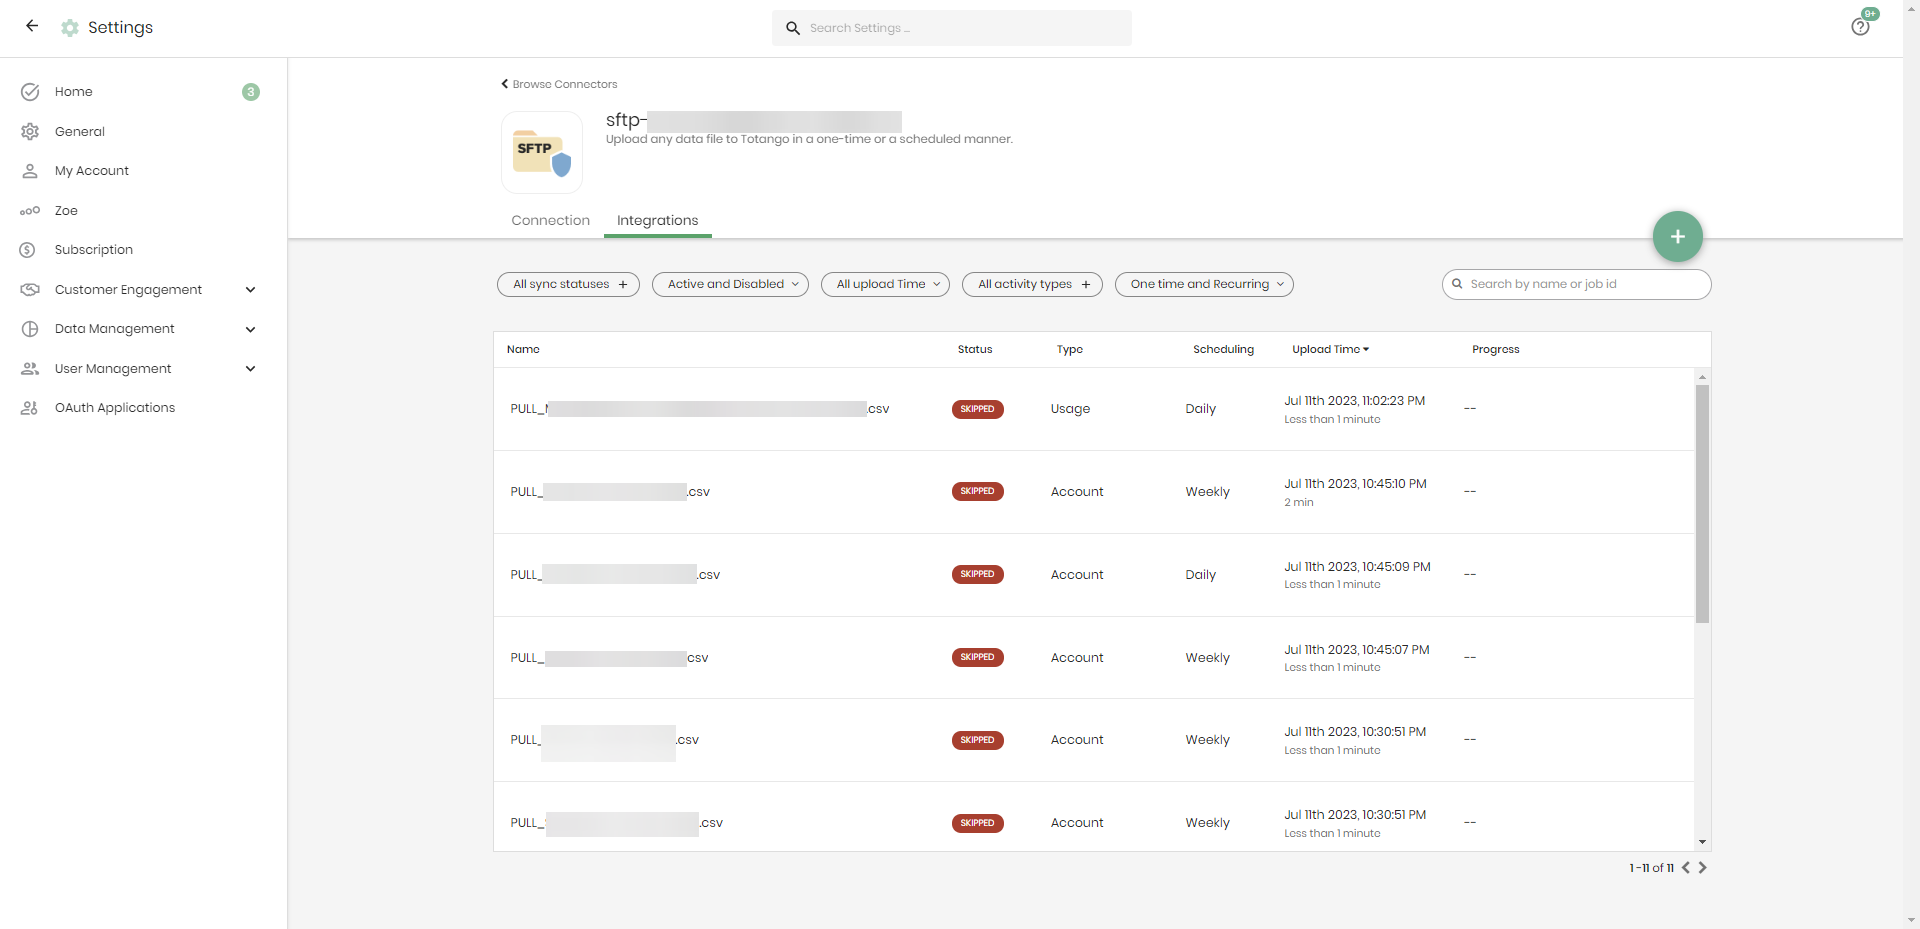

# Libraries

In [2]:
#Importing required libraries
import datetime
import json
import pandas as pd
import requests
#from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
from datetime import datetime
from flatten_json import flatten
from datetime import timedelta

# Authentication and API Post

## Authentication

In [22]:
#JSON Authentication
headers = {
    'app-token': 'ENTER YOUT API TOKEN HERE',
    'Content-Type': 'application/json',
}

#connectorid can be got from Totango UI
response = requests.get(
    'https://api.totango.com/api/v3/integrations/job/?integrationType=csv_file&connectorId=PUT CONNECTOR ID HERE',
    headers=headers)

## Filtering and Renaming Response

In [23]:
#data = pd.DataFrame(json_normalize(data['recurring']))
data = response.json()
data = pd.DataFrame(pd.json_normalize(data['recurring']))

In [24]:
#Filtering the API Result to only required columns
fdata = data[[
    'id', 'job_configuration.description',
    'job_configuration.notificationsEmail', 'job_configuration.name',
    'scheduling.scheduleType', 'execution.transactionId',
    'execution.triggerType', 'execution.result', 'execution.dataType',
    'execution.ingestionDetails.totalRecords',
    'execution.ingestionDetails.validRecords',
    'execution.ingestionDetails.invalidRecords',
    'execution.ingestionDetails.processedRecords',
    'execution.ingestionDetails.duplicateRecords', 'execution.startTime',
    'execution.finishTimeProcessing', 'execution.finishTimeIndexing',
    'execution.additionalInfo.fileSizeInBytes', 'execution.errors'
]]

In [38]:
#renaming totango field names into a shortened clear name without spaces
fdata.rename(
    columns={
        'job_configuration.description': 'job_configuration_description',
        'job_configuration.notificationsEmail': 'job_configuration_notificationsEmail',
        'job_configuration.name': 'job_configuration_name',
        'scheduling.scheduleType': 'scheduling_scheduleType',
        'execution.transactionId': 'execution_transactionId',
        'execution.triggerType': 'execution_triggerType',        
        'execution.result': 'execution_result',
        'execution.dataType': 'execution_dataType',
        'execution.ingestionDetails.totalRecords': 'execution_ingestionDetails_totalRecords',
        'execution.ingestionDetails.validRecords': 'execution_ingestionDetails_validRecords',
        'execution.ingestionDetails.invalidRecords': 'execution_ingestionDetails_invalidRecords',
        'execution.ingestionDetails.processedRecords': 'execution_ingestionDetails_processedRecords',
        'execution.ingestionDetails.duplicateRecords': 'execution_ingestionDetails_duplicateRecords',
        'execution.startTime': 'execution_startTime',
        'execution.finishTimeProcessing': 'execution_finishTimeProcessing',
        'execution.finishTimeIndexing': 'execution_finishTimeIndexing',
        'execution.additionalInfo.fileSizeInBytes': 'execution_additionalInfo_fileSizeInBytes',
        'execution.errors': 'execution_errors'     
    },
    inplace=True)

In [37]:
fdata['snapshot_date'] = datetime.now().isoformat()
fdata['snapshot_date_only'] = datetime.today().strftime('%Y-%m-%d')

In [27]:
#explode the nested JSON in execution errors into individual components
fdata = fdata.explode("execution_errors")

## JSON Error Column Decipher 

In [10]:
# The 'execution_errors' column contains a nested JSON structure, which needs to be unpacked.
# Create a DataFrame from the dictionary obtained from 'execution_errors' items, converting each value to a pandas Series.
df_3sub = pd.DataFrame(
    dict([(k, pd.Series(v)) for k, v in fdata['execution_errors'].items()]))

# The index is reset, but the result isn't assigned to any variable, so this line doesn't have any effect.
df_3sub.reset_index(col_level=0)

# Transpose the DataFrame to switch rows with columns.
df_3_error = df_3sub.T

# Concatenate the transposed DataFrame and the original DataFrame column-wise, forming a semi-final DataFrame.
semi_final = pd.concat([df_3_error, fdata], axis=1)

# Similar steps are repeated for the 'extraInfo' column in the semi-final DataFrame.
df_4sub = pd.DataFrame(
    dict([(k, pd.Series(v)) for k, v in semi_final['extraInfo'].items()]))

# The index is reset again, but the result isn't assigned to any variable, so this line also doesn't have any effect.
df_4sub.reset_index(col_level=1)

# Transpose the DataFrame to switch rows with columns.
df_4_error = df_4sub.T

# Concatenate the transposed DataFrame and the semi-final DataFrame column-wise, forming the final DataFrame.
final = pd.concat([df_4_error, semi_final], axis=1)

# Drop column with index 0. Assuming that it contains undesired or unnecessary data.
final = final.drop(columns=0)

# Drop 'execution_errors', 'extraInfo', and 'linesNum' columns from the final DataFrame, as they are no longer needed.
final = final.drop(columns=['execution_errors', 'extraInfo', 'linesNum'])

#Cleanups
final.job_configuration_name = final['job_configuration_name'].str.replace(".csv","")
final['job_name'] = final.job_configuration_name.combine_first(final.job_configuration_description)

# Filter

In [16]:
#Filtering all columns after unpacking the JSON and transpose
final = final[[
    'id',
    'job_name',
    'job_configuration_notificationsEmail',   
    'scheduling_scheduleType',
    'execution_transactionId',
    'execution_triggerType',
    'execution_result', 'execution_dataType',
    'execution_ingestionDetails_totalRecords','execution_ingestionDetails_validRecords',
    'execution_ingestionDetails_invalidRecords','execution_ingestionDetails_processedRecords',
    'execution_ingestionDetails_duplicateRecords','execution_startTime',
    'execution_finishTimeProcessing', 'execution_finishTimeIndexing',
    'execution_additionalInfo_fileSizeInBytes',
    'snapshot_date',
    'accountId', 
    'collectionId', 
    'lastLine',
    'code', 
    'description',
    'snapshot_date_only'
]]

In [20]:
print(final.columns.tolist())

['id', 'job_name', 'job_configuration_notificationsEmail', 'scheduling_scheduleType', 'execution_transactionId', 'execution_triggerType', 'execution_result', 'execution_dataType', 'execution_ingestionDetails_totalRecords', 'execution_ingestionDetails_validRecords', 'execution_ingestionDetails_invalidRecords', 'execution_ingestionDetails_processedRecords', 'execution_ingestionDetails_duplicateRecords', 'execution_startTime', 'execution_finishTimeProcessing', 'execution_finishTimeIndexing', 'execution_additionalInfo_fileSizeInBytes', 'snapshot_date', 'accountId', 'collectionId', 'lastLine', 'code', 'description', 'snapshot_date_only']
